In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 



In [6]:
X.fillna(0, inplace=True)
X.isna().sum()

/var/folders/fj/8n7rcf2d6wjffyl_fphfsnl00000gn/T/ipykernel_5235/752494309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


/var/folders/fj/8n7rcf2d6wjffyl_fphfsnl00000gn/T/ipykernel_5235/752494309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64

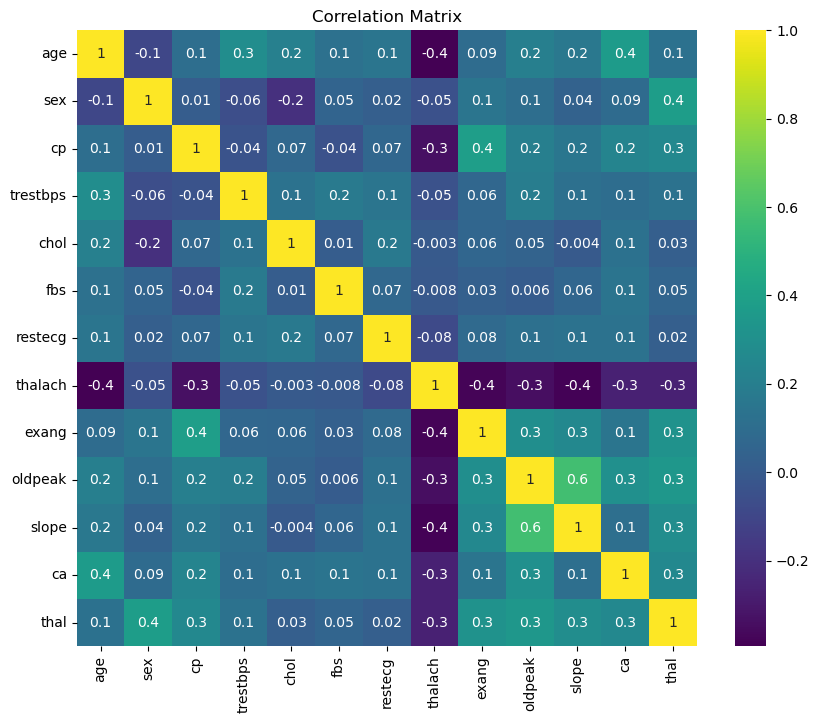

In [7]:
numeric_cols = X.select_dtypes(include=[np.number]).columns
corr_martix = X[numeric_cols].corr()
fig, ax = plt.subplots(figsize =(10, 8))
sns.heatmap(corr_martix,
            annot=True,
            fmt='.1g',
            cmap='viridis',)
plt.title('Correlation Matrix')
plt.show()

In [16]:
y = y.copy()
# Convert 'num' column to binary: 1 if not 0, else 0
y_bin = y['num'].apply(lambda v: 1 if v != 0 else 0)
y_bin.value_counts()

In [8]:
cat_values = ['cp', 'restecg', 'slope', 'thal']
not_used = ['ca', 'sex', 'fbs',  'exang']
num_values = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

preprocess = ColumnTransformer([
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_values),
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ]), num_values)
])

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [19]:
# Encode X using the preprocessing pipeline
X_encoded = preprocess.fit_transform(X)
# Use y_bin as the binary target (ensure it exists from previous cell)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_bin, test_size=0.2, random_state=42, stratify=y_bin)

In [11]:

def make_scoring(y):
    # binary or multiclass?
    n_classes = len(np.unique(y))
    if n_classes == 2:
        scoring = {
            "accuracy": "accuracy",
            "precision": make_scorer(precision_score, zero_division=0),
            "recall": make_scorer(recall_score, zero_division=0),
            "f1": make_scorer(f1_score, zero_division=0),
            "roc_auc": "roc_auc",              # binary OK
        }
    else:
        # macro = average per class equally; weighted = accounts for class frequency
        scoring = {
            "accuracy": "accuracy",
            "precision_macro": "precision_macro",
            "recall_macro": "recall_macro",
            "f1_macro": "f1_macro",
            # Multiclass ROC-AUC; requires predict_proba
            "roc_auc_ovr_weighted": "roc_auc_ovr_weighted",
        }
    return scoring

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = make_scoring(y)
scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score="raise")
# Inspect means
{k: (v.mean(), v.std()) for k, v in ((f"test_{m}", scores[f"test_{m}"]) for m in scoring)}


{'test_accuracy': (0.6963387978142077, 0.033957956696722975),
 'test_precision': (0.6834590246354952, 0.0653616815190776),
 'test_recall': (0.6616402116402117, 0.09550374473564581),
 'test_f1': (0.6640763111144594, 0.041905258896681334),
 'test_roc_auc': (0.6940776815776816, 0.03242745999441323)}

In [20]:
clf_model = DecisionTreeClassifier(random_state=42)
clf_model = clf_model.fit(X_train, y_train)

[Text(0.4921875, 0.9545454545454546, 'cat__thal_3.0 <= 0.5\ngini = 0.497\nsamples = 242\nvalue = [131, 111]\nclass = No HD'),
 Text(0.2708333333333333, 0.8636363636363636, 'cat__cp_4.0 <= 0.5\ngini = 0.358\nsamples = 107\nvalue = [25, 82]\nclass = Yes HD'),
 Text(0.11458333333333333, 0.7727272727272727, 'cat__slope_2.0 <= 0.5\ngini = 0.5\nsamples = 34\nvalue = [17, 17]\nclass = No HD'),
 Text(0.041666666666666664, 0.6818181818181818, 'cat__cp_2.0 <= 0.5\ngini = 0.355\nsamples = 13\nvalue = [10, 3]\nclass = No HD'),
 Text(0.020833333333333332, 0.5909090909090909, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]\nclass = No HD'),
 Text(0.0625, 0.5909090909090909, 'num__oldpeak <= 0.15\ngini = 0.5\nsamples = 6\nvalue = [3, 3]\nclass = No HD'),
 Text(0.041666666666666664, 0.5, 'num__trestbps <= 161.0\ngini = 0.375\nsamples = 4\nvalue = [3, 1]\nclass = No HD'),
 Text(0.020833333333333332, 0.4090909090909091, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]\nclass = No HD'),
 Text(0.0625, 0.4090909090909091

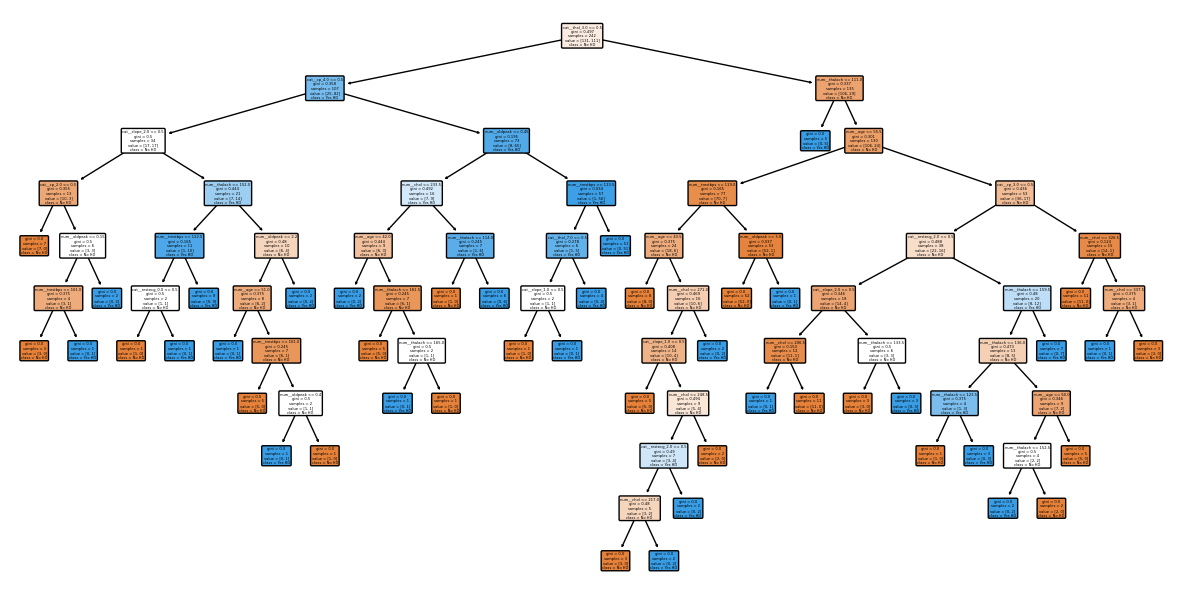

In [24]:

try:
    feature_names = encoded_feature_names
except NameError:
    
    try:
        feature_names = preprocess.get_feature_names_out()
    except AttributeError:
        feature_names = None

plt.figure(figsize=(15, 7.5))
plot_tree(clf_model,
          filled=True,
          rounded=True,
          class_names=['No HD', 'Yes HD'],
          feature_names=feature_names)

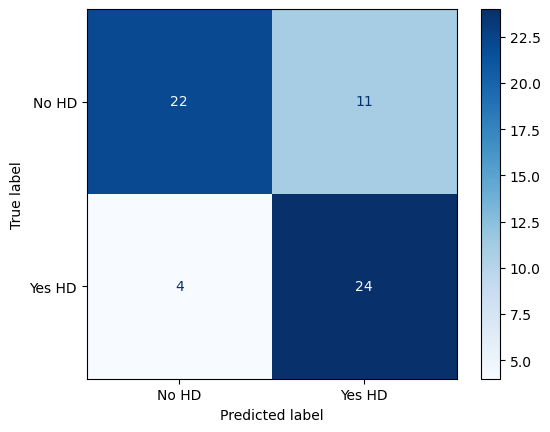

In [ ]:
y_pred = clf_model.predict(X_test)

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No HD', 'Yes HD'])
disp.plot(cmap='Blues')
plt.show()

In [ ]:
# --- Cost Complexity Pruning ---
# This process finds the optimal pruning level (alpha) for the decision tree.
# A smaller tree is less complex and less likely to overfit.

# Get the path of alphas and impurities for pruning
tree_path = clf_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = tree_path.ccp_alphas
# The last alpha corresponds to a trivial tree (just the root), so we remove it.
ccp_alphas = ccp_alphas[:-1]

# Create a list to store decision trees for each alpha
clf_dts = []

# Train a decision tree for each alpha value
for ccp_alpha in ccp_alphas:
    clf_model = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_model.fit(X_train, y_train)
    clf_dts.append(clf_model)

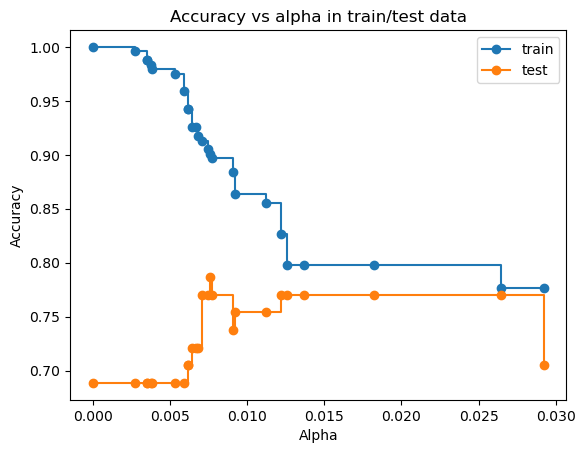

In [ ]:
# --- Accuracy vs. Alpha for Training and Testing Sets ---
# This plot helps visualize how the model's accuracy changes with different levels of pruning (alpha).

# Calculate the accuracy scores for each pruned tree on both training and testing data
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

# Plot the results
fig, ax = plt.subplots()
ax.set_xlabel('Alpha')
ax.set_ylabel('Accuracy')
ax.set_title("Accuracy vs alpha in train/test data")
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
ax.legend()
# The ideal alpha is often where the test accuracy is highest, before it starts to decrease.

<Axes: xlabel='tree'>

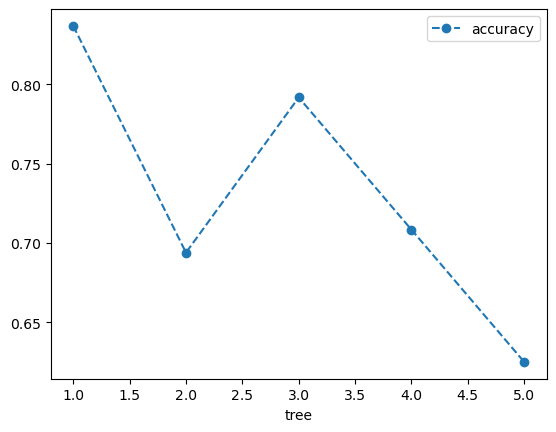

In [ ]:
# --- Cross-Validation for a Specific Alpha ---
# After choosing a promising alpha from the plot, we can verify its performance using cross-validation.

# Create a decision tree with the chosen alpha value
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.0075)
# Perform 5-fold cross-validation to get a more robust estimate of the accuracy
scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df = pd.DataFrame(data={'tree': range(1,6), 'accuracy': scores})

# Plot the accuracy for each fold
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

<Axes: xlabel='alpha'>

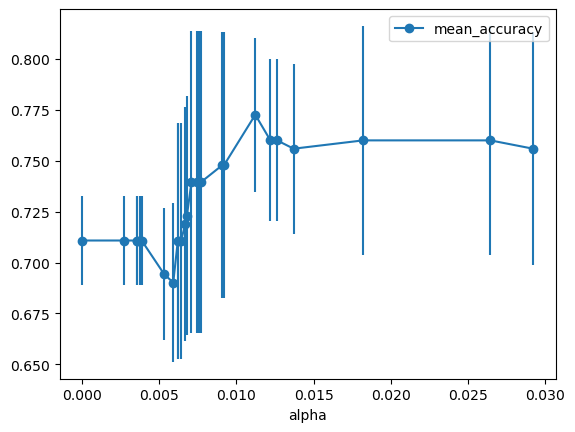

In [ ]:
# --- Cross-Validation for All Alphas ---
# To be more thorough, we can perform cross-validation for every alpha value.
# This gives a more stable measure of how each alpha performs.

alpha_loop_scores = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_scores.append([ccp_alpha, np.mean(scores), np.std(scores)])

# Store the results in a DataFrame
alpha_result = pd.DataFrame(alpha_loop_scores, columns=['alpha', 'mean_accuracy', 'std_accuracy'])

# Plot the mean accuracy with error bars (standard deviation) for each alpha
alpha_result.plot(x='alpha', y='mean_accuracy', yerr='std_accuracy', marker='o')

In [45]:
# --- Finding the Best Alpha ---
# We can now inspect the results to find the alpha that gives the highest mean accuracy.
ideal_alpha = alpha_result.loc[alpha_result['mean_accuracy'].idxmax(), 'alpha']
ideal_alpha

0.011219634360130223

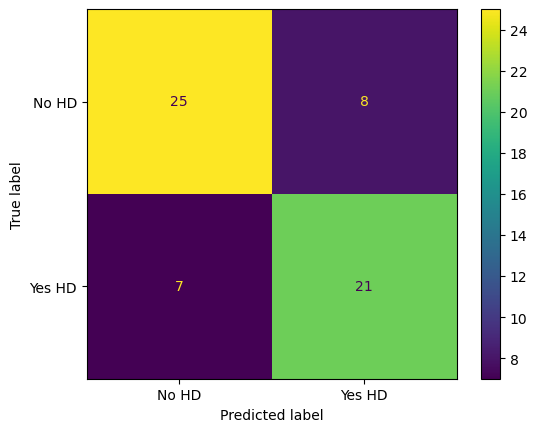

In [46]:
final_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ideal_alpha)
final_tree.fit(X_train, y_train)
predicted_final = final_tree.predict(X_test)
final_cm = confusion_matrix(y_test, predicted_final)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=['No HD', 'Yes HD'])
final_disp.plot(cmap='viridis')

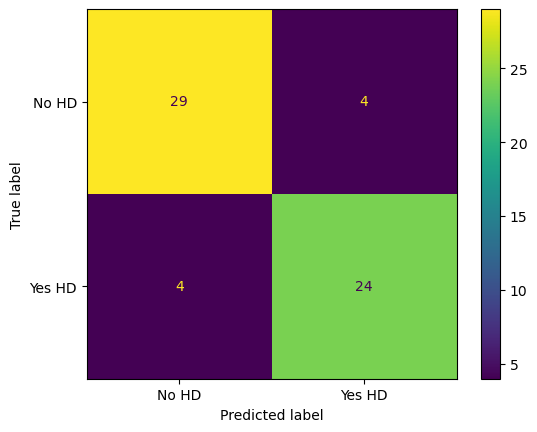

In [62]:
forest_model = RandomForestClassifier(random_state=42, 
                                      n_estimators=200,
                                      max_depth=20,
                                      min_samples_split=2,
                                      min_samples_leaf=1,
                                      oob_score=True,
                                      n_jobs=-1)
forest_model.fit(X_train, y_train)
y_forest_pred = forest_model.predict(X_test)
forest_cm = confusion_matrix(y_test, y_forest_pred)
forest_disp = ConfusionMatrixDisplay(confusion_matrix=forest_cm, display_labels=['No HD', 'Yes HD'])
forest_disp.plot(cmap='viridis')

In [63]:
print("Decision OOB score: ", forest_model.oob_score_)

Decision OOB score:  0.7231404958677686


In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

param_dist = {
    "n_estimators": [100, 300, 500, 1000],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 5, 10, 20],
    "max_features": ["sqrt", "log2", None],
}

search = RandomizedSearchCV(
    rf, param_dist, n_iter=30, cv=5, scoring="f1_macro", n_jobs=-1, random_state=42
)
search.fit(X_train, y_train)

print(search.best_params_)
best_rf = search.best_estimator_

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'log2', 'max_depth': 20}
